# Semantic Retrieval with Word2Vec: From Scratch to Pre-trained

This notebook demonstrates how word embeddings can be used for document retrieval. We will see how data size and training time affect results and how to visualize these relationships in 2D space.

### Dependencies
Ensure you have the following installed:
```bash
pip install gensim scikit-learn numpy matplotlib
```

In [1]:
!pip install gensim scikit-learn numpy matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

## 1. Helper Functions
We need a way to convert a document (list of words) into a single vector. We'll use the **Centroid Method** (averaging word vectors).

In [3]:
def get_doc_vector(tokens, model, is_pretrained=False):
    # Pre-trained models use model[word], custom models use model.wv[word]
    wv = model if is_pretrained else model.wv
    
    valid_vectors = [wv[word] for word in tokens if word in wv]
    
    if not valid_vectors:
        # Return zero vector if no words match vocabulary
        vector_size = model.vector_size
        return np.zeros(vector_size)
    
    return np.mean(valid_vectors, axis=0)

def plot_embeddings_with_query(doc_vectors, doc_labels, query_vector, title="Semantic Space"):
    # Combine all vectors for PCA
    all_vecs = np.vstack([doc_vectors, query_vector])
    
    pca = PCA(n_components=2)
    coords = pca.fit_transform(all_vecs)
    
    plt.figure(figsize=(12, 7))
    # Plot documents
    plt.scatter(coords[:-1, 0], coords[:-1, 1], c='blue', label='Documents', alpha=0.6)
    # Plot query
    plt.scatter(coords[-1, 0], coords[-1, 1], c='red', marker='*', s=300, label='Query', edgecolors='black')
    
    # Annotate documents
    for i, label in enumerate(doc_labels):
        plt.annotate(f"Doc {i}", (coords[i, 0], coords[i, 1]), xytext=(5, 5), textcoords='offset points')
        
    plt.legend()
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

## 2. Scenario A: The Small Data Limitation
In a tiny corpus, word vectors are almost random because there isn't enough context. We'll use Cosine Similarity to find the closest match.

Results for Query: 'computer science and learning' (Small Data Model)
Rank 1: The weather is sunny and warm today | Score: 0.2600


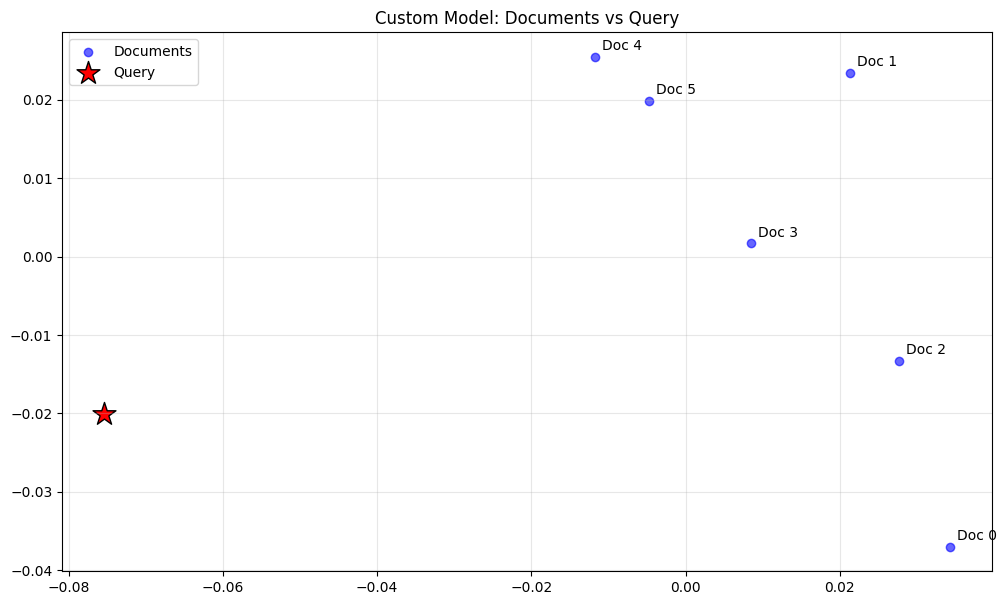

In [8]:
corpus_small = [
    "The cat sits on the mat",
    "Dogs are loyal and friendly animals",
    "Artificial intelligence is transforming the world",
    "A quick brown fox jumps over the lazy dog",
    "Machine learning models require data to train",
    "The weather is sunny and warm today"
]

tokenized_small = [d.lower().split() for d in corpus_small]

# Training with very few epochs on tiny data
model_small = Word2Vec(sentences=tokenized_small, vector_size=20, window=5, min_count=1, epochs=5)

query = "computer science and learning"
query_tokens = query.lower().split()
query_vec_small = get_doc_vector(query_tokens, model_small).reshape(1, -1)
doc_vecs_small = np.array([get_doc_vector(t, model_small) for t in tokenized_small])

sims = cosine_similarity(query_vec_small, doc_vecs_small).flatten()
print(f"Results for Query: '{query}' (Small Data Model)")
print("Rank 1:", corpus_small[np.argmax(sims)], f"| Score: {np.max(sims):.4f}")


plot_embeddings_with_query(doc_vecs_small, corpus_small, query_vec_small, title="Custom Model: Documents vs Query")

## 3. Scenario B: Augmented Training (Better Scratch Model)
Increasing training iterations (epochs) helps the model recognize patterns better.

Results for Query: 'computer science and learning' (Better Model)
Rank 1: Data science and machine learning are related | Score: 0.8675
Rank 2: Computer science involves programming and math | Score: 0.8176


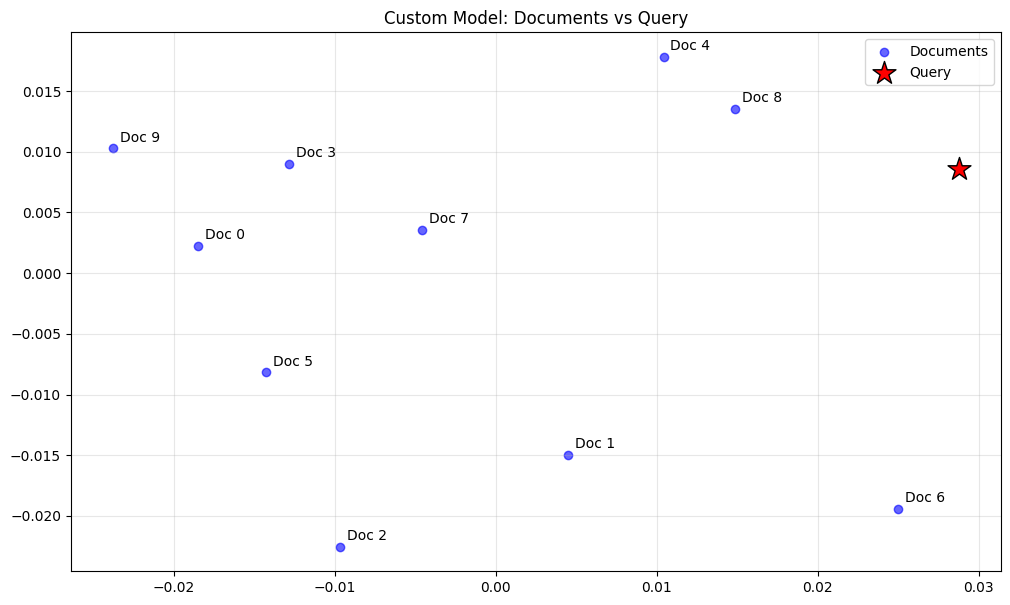

In [5]:
corpus_better = corpus_small + [
    "Computer science involves programming and math",
    "Neural networks are a part of deep learning",
    "Data science and machine learning are related",
    "The internet connects computers globally"
]

tokenized_better = [d.lower().split() for d in corpus_better]

# Increase epochs to 200 to let vectors settle
model_better = Word2Vec(sentences=tokenized_better, vector_size=50, window=3, min_count=1, epochs=200)

query_vec_better = get_doc_vector(query_tokens, model_better).reshape(1, -1)
doc_vecs_better = np.array([get_doc_vector(t, model_better) for t in tokenized_better])

sims_better = cosine_similarity(query_vec_better, doc_vecs_better).flatten()
print(f"Results for Query: '{query}' (Better Model)")
best_idx = np.argsort(sims_better)[::-1]
for i in range(2):
    idx = best_idx[i]
    print(f"Rank {i+1}: {corpus_better[idx]} | Score: {sims_better[idx]:.4f}")

plot_embeddings_with_query(doc_vecs_better, corpus_better, query_vec_better, title="Custom Model: Documents vs Query")

## 4. Scenario C: Pre-trained Word2Vec
Using a model trained on Wikipedia (GloVe) provides high-quality results immediately.

Loading Pre-trained Model (glove-wiki-gigaword-50)...

Top 3 results for: 'computer science and learning' (Pre-trained Model)
1. Computer science involves programming and math (Score: 0.9709)
2. Data science and machine learning are related (Score: 0.9466)
3. Machine learning models require data to train (Score: 0.8652)


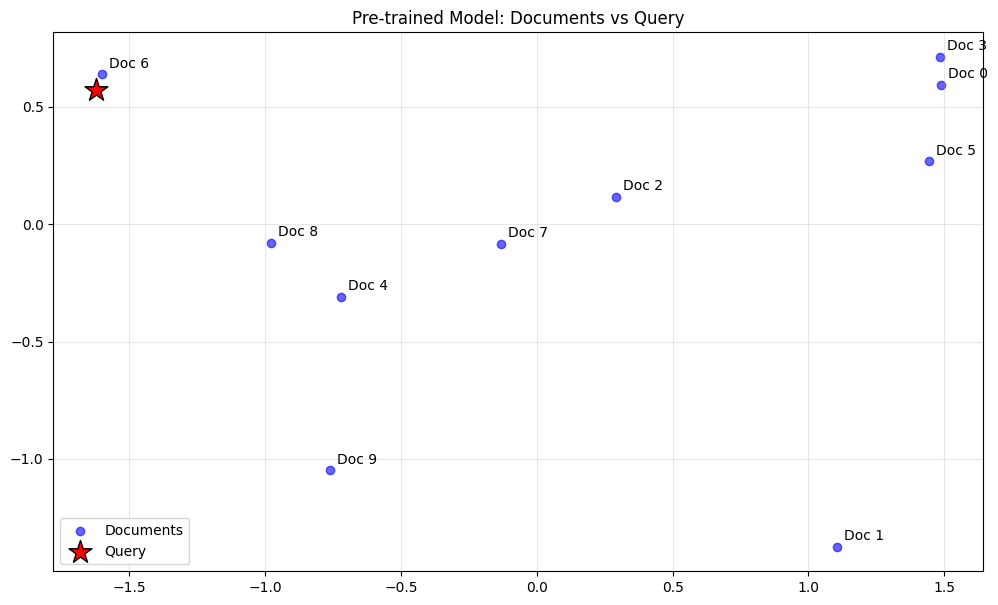

In [6]:
print("Loading Pre-trained Model (glove-wiki-gigaword-50)...")
pretrained_wv = api.load('glove-wiki-gigaword-50')

query_vec_pre = get_doc_vector(query_tokens, pretrained_wv, is_pretrained=True).reshape(1, -1)
doc_vecs_pre = np.array([get_doc_vector(t, pretrained_wv, is_pretrained=True) for t in tokenized_better])

sims_pre = cosine_similarity(query_vec_pre, doc_vecs_pre).flatten()
indices = np.argsort(sims_pre)[::-1]

print(f"\nTop 3 results for: '{query}' (Pre-trained Model)")
for i in range(3):
    idx = indices[i]
    print(f"{i+1}. {corpus_better[idx]} (Score: {sims_pre[idx]:.4f})")

plot_embeddings_with_query(doc_vecs_pre, corpus_better, query_vec_pre, title="Pre-trained Model: Documents vs Query")